# side model feature selection

In [1]:
import pandas as pd

df_features = pd.read_parquet("data/features_45m.parquet")
df_features.shape

(59137, 11841)

In [2]:
import numpy as np
from jesse import utils

label = np.load("data/label_dollar_bar_45m.npy")
df_label = utils.numpy_candles_to_dataframe(label[:, :6]).set_index("date")
df_label["side_label"] = label[:, 6]
df_label.head(1)

,open,close,high,low,volume,side_label
date,,,,,,
2020-01-01 01:22:00,7188.72,7185.59,7260.43,7174.0,52620.421,-1.0


In [3]:
side_features = df_features.iloc[538:]
side_label = df_label.iloc[538:]

side_label["side_label"] = (side_label["side_label"].astype(int) == 1).astype(int)
side_label = side_label["side_label"].to_numpy()

print(side_features.shape)
print(side_label.shape)

side_features.isna().sum(axis=0).sort_values(ascending=False)

/var/folders/h9/d_xpszfn6yz9r8zww450m44w0000gn/T/ipykernel_2137/1267099876.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  side_label["side_label"] = (side_label["side_label"].astype(int) == 1).astype(int)


(58599, 11841)
(58599,)


10m_ac_0                    0
4h_ac_4                     0
45m_williams_r_ddt_lag35    0
45m_williams_r_ddt_lag36    0
45m_williams_r_ddt_lag37    0
                           ..
45m_ac_2                    0
45m_ac_3                    0
45m_ac_4                    0
45m_ac_5                    0
4h_williams_r_ddt_lag39     0
Length: 11841, dtype: int64

In [4]:
from feature_engine.selection import SelectByInformationValue

sel = SelectByInformationValue(
    bins=5,
    strategy="equal_frequency",
    threshold=0.02,
)
sel.fit(side_features, side_label)

SelectByInformationValue(strategy='equal_frequency', threshold=0.02)

In [ ]:
# meta feature selection
# from feature_engine.selection import MRMR

# sel = MRMR(
#     method="FCQ",
#     max_features=side_features.shape[1] // 2,
#     scoring="f1",
#     cv=4,
#     regression=False,
#     n_jobs=-1,
# )
# sel.fit(side_features, side_label)

In [7]:
sel.information_values_

{'10m_ac_0': 0.0007674450414765105,
 '10m_ac_1': 0.0006222563796829432,
 '10m_ac_2': 0.0011301407456105342,
 '10m_ac_3': 0.00031044647152873487,
 '10m_ac_4': 0.0003639216034276848,
 '10m_ac_5': 0.0002255148701857198,
 '10m_ac_6': 0.0006877524095947199,
 '10m_ac_7': 0.0008080904607747018,
 '10m_ac_8': 0.0006030931165282701,
 '10m_ac_9': 0.001041807958257667,
 '10m_ac_10': 0.00014115120493591368,
 '10m_ac_11': 0.000729068127513542,
 '10m_ac_12': 0.001364796830014599,
 '10m_ac_13': 0.0012018801255315428,
 '10m_ac_14': 0.0011214051928624769,
 '10m_ac_15': 0.0009320953212957513,
 '10m_ac_16': 0.0017976032413375433,
 '10m_ac_17': 0.0025511612801568,
 '10m_ac_18': 0.000642983374829369,
 '10m_ac_19': 0.0013858278075428087,
 '10m_ac_20': 0.0005603074197940555,
 '10m_ac_21': 0.0006841833372148518,
 '10m_ac_22': 0.001259134315848329,
 '10m_ac_23': 0.002113206830897263,
 '10m_ac_24': 0.0025906013968609114,
 '10m_ac_25': 0.0020335958393505665,
 '10m_ac_26': 0.0018545343582651252,
 '10m_ac_27': 0.00

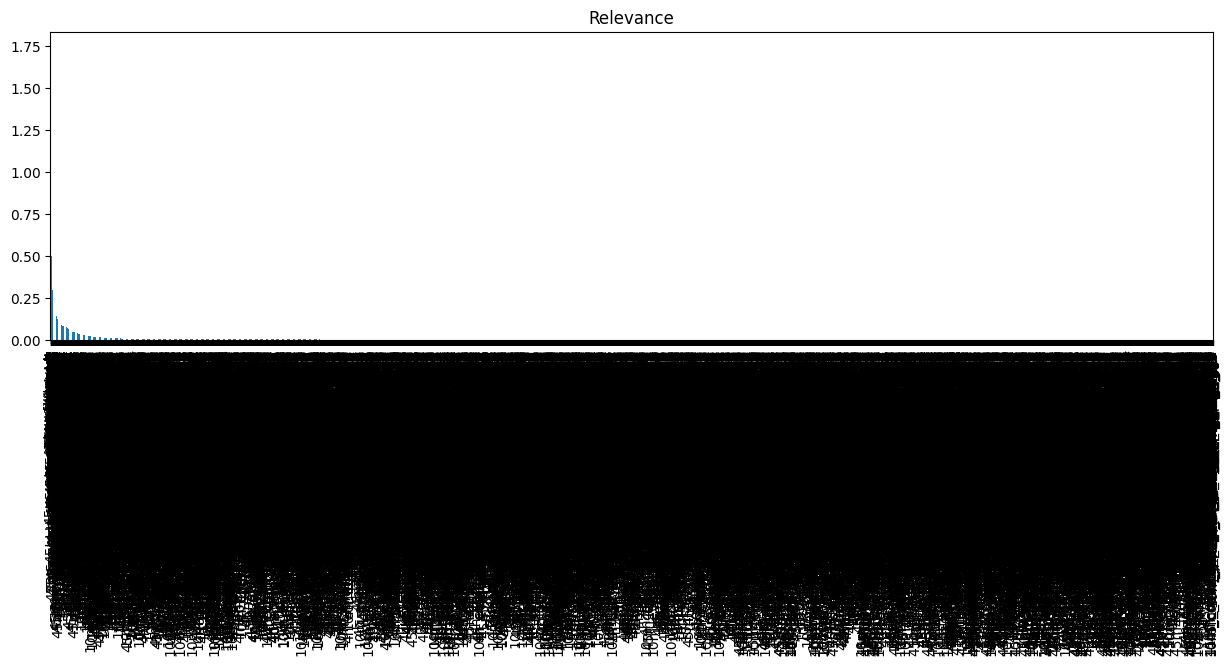

In [10]:
import matplotlib.pyplot as plt

if sel.__class__.__name__ == "SelectByInformationValue":
    side_res = pd.Series(
        sel.information_values_, index=sel.variables_
    ).sort_values(ascending=False)
    side_res.plot.bar(
        figsize=(15, 4)
    )
elif sel.__class__.__name__ == "MRMR":
    side_res = pd.Series(
        sel.relevance_, index=sel.variables_
    ).sort_values(ascending=False)
    side_res.plot.bar(
        figsize=(15, 4)
    )
plt.title("Relevance")
plt.show()

In [11]:
side_res

45m_williams_r                    1.745751
45m_acc_swing_index_dt            1.223450
45m_fisher_dt                     0.858963
45m_trendflex_dt                  0.812488
45m_vwap_dt                       0.749967
                                    ...   
45m_williams_r_ddt_lag39          0.000008
45m_adaptive_bp_lead_ddt_lag22    0.000007
45m_acr                           0.000000
4h_acr                            0.000000
10m_acr                           0.000000
Length: 11841, dtype: float64

In [12]:
len([k for k, v in side_res.to_dict().items() if v > 0.02])

440

In [13]:
import json

with open(f"data/{sel.__class__.__name__}_side_features.json", "w") as f:
    json.dump(side_res.to_dict(), f, indent=4)

In [3]:
import json
import pandas as pd

with open("data/mrmr_side_features.json", "r") as f:
    side_res = pd.Series(json.load(f))

In [4]:
SHORT_TERM = "10m"
MEDIUM_TERM = "45m"
LONG_TERM = "4h"

feature_info = {
    "all": [],
    "side": {SHORT_TERM: [], MEDIUM_TERM: [], LONG_TERM: []},
    "meta": {SHORT_TERM: [], MEDIUM_TERM: [], LONG_TERM: [], "model_res": []},
}

for k, v in side_res.to_dict().items():
    if v > 10:
        if k.startswith(f"{SHORT_TERM}_"):
            feature_info["side"][SHORT_TERM].append(k)
            feature_info["all"].append(k.replace(f"{SHORT_TERM}_", ""))
        elif k.startswith(f"{MEDIUM_TERM}_"):
            feature_info["side"][MEDIUM_TERM].append(k)
            feature_info["all"].append(k.replace(f"{MEDIUM_TERM}_", ""))
        elif k.startswith(f"{LONG_TERM}_"):
            feature_info["side"][LONG_TERM].append(k)
            feature_info["all"].append(k.replace(f"{LONG_TERM}_", ""))

feature_info["all"] = sorted(list(set(feature_info["all"])))
feature_info["side"][SHORT_TERM] = sorted(list(set(feature_info["side"][SHORT_TERM])))
feature_info["side"][MEDIUM_TERM] = sorted(list(set(feature_info["side"][MEDIUM_TERM])))
feature_info["side"][LONG_TERM] = sorted(list(set(feature_info["side"][LONG_TERM])))

feature_info["meta"][SHORT_TERM] = sorted(list(set(feature_info["meta"][SHORT_TERM])))
feature_info["meta"][MEDIUM_TERM] = sorted(list(set(feature_info["meta"][MEDIUM_TERM])))
feature_info["meta"][LONG_TERM] = sorted(list(set(feature_info["meta"][LONG_TERM])))
feature_info["meta"]["model_res"] = sorted(list(set(feature_info["meta"]["model_res"])))

with open("custom_indicators/feature_info.json", "w") as f:
    json.dump(feature_info, f, indent=4)

# meta model feature selection

In [14]:
import lightgbm as lgb
import numpy as np
import pandas as pd

from custom_indicators.config import SIDE_ALL

df_features = pd.read_parquet("data/features_45m.parquet")
df_label = pd.read_parquet("data/label_meta_45m.parquet")

model_side = lgb.Booster(model_file="custom_indicators/models/model_side.txt")
model_side_res = model_side.predict(df_features[SIDE_ALL])
df_features["model_side_res"] = model_side_res
print(df_features.shape)

assert df_features.shape[0] == df_label.shape[0]
print(df_label.shape)
df_label.head()

(59137, 11842)
(59137, 9)


,open,high,low,close,volume,ret,trgt,bin,side
index,,,,,,,,,
2020-01-01 01:22:00+00:00,7188.72,7260.43,7174.00,7185.59,52620.421,NaN,NaN,0.0,0.0
2020-01-01 23:31:00+00:00,7185.59,7209.59,7101.00,7107.40,53122.462,NaN,NaN,0.0,0.0
2020-01-02 13:51:00+00:00,7107.67,7154.06,6922.00,6960.29,54102.611,NaN,NaN,0.0,0.0
2020-01-02 20:22:00+00:00,6960.73,7300.00,6863.44,7239.60,54169.888,NaN,NaN,0.0,0.0
2020-01-03 04:45:00+00:00,7239.54,7333.00,7148.14,7294.00,53029.463,NaN,NaN,0.0,0.0


In [2]:
meta_features = df_features[583:]
meta_label = df_label["bin"][583:]

# meta_features = meta_features[meta_label["ret"].notna()]
# meta_label = meta_label[meta_label["ret"].notna()]["bin"]

print(meta_features.shape)
print(meta_label.shape)

meta_label.value_counts()

(58555, 11842)
(58555,)


bin
0.0    42853
1.0    15702
Name: count, dtype: int64

In [3]:
# meta feature selection
from feature_engine.selection import MRMR

sel = MRMR(
    method="FCQ",
    max_features=meta_features.shape[1] // 2,
    scoring="f1",
    cv=4,
    regression=False,
    n_jobs=-1,
)
sel.fit(meta_features, meta_label)

MRMR(cv=4, max_features=5921, method='FCQ', n_jobs=-1, scoring='f1')

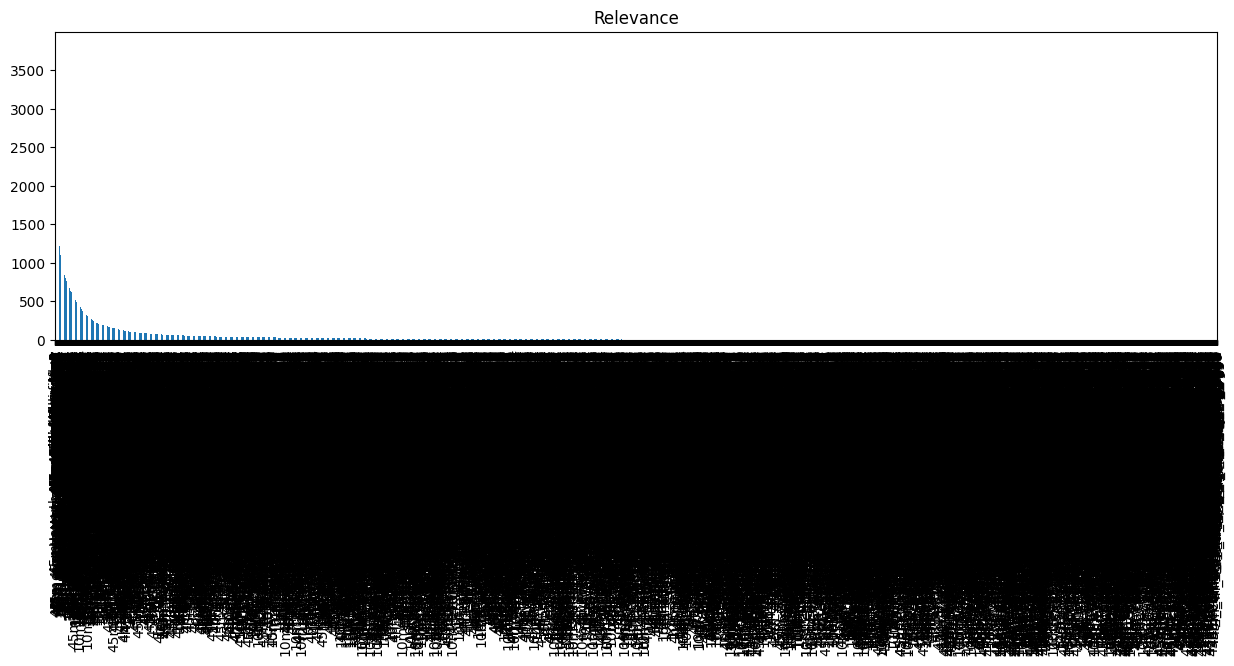

In [4]:
import matplotlib.pyplot as plt

pd.Series(sel.relevance_, index=sel.variables_).sort_values(ascending=False).plot.bar(
    figsize=(15, 4)
)
plt.title("Relevance")
plt.show()

In [5]:
meta_res = pd.Series(sel.relevance_, index=sel.variables_).sort_values(ascending=False)
meta_res

45m_trendflex                    3.808890e+03
45m_williams_r                   3.451339e+03
45m_trendflex_lag1               3.272556e+03
45m_fisher                       3.066888e+03
45m_williams_r_lag1              3.023824e+03
                                     ...     
10m_homodyne_lag30               1.812181e-06
45m_forecast_oscillator_lag39    9.761079e-07
45m_trendflex_ddt_lag36          7.377034e-07
45m_williams_r_ddt_lag12         6.234446e-07
45m_adaptive_bp_lead_dt_lag35    1.114992e-07
Length: 11842, dtype: float64

In [6]:
import json

with open("data/mrmr_meta_features.json", "w") as f:
    json.dump(meta_res.to_dict(), f, indent=4)

In [2]:
import json
import pandas as pd

with open("data/mrmr_meta_features.json", "r") as f:
    meta_res = pd.Series(json.load(f))

In [3]:
meta_res.to_dict()["model_side_res"]

2041.1730942210788

In [4]:
len([k for k, v in meta_res.to_dict().items() if v > 10])

4438

In [5]:
from pathlib import Path

feature_info = Path("custom_indicators/feature_info.json")
if feature_info.exists():
    with open(feature_info, "r") as f:
        feature_info = json.load(f)

SHORT_TERM = "10m"
MEDIUM_TERM = "45m"
LONG_TERM = "4h"

for k, v in meta_res.to_dict().items():
    if v > 1:
        if k.startswith(f"{SHORT_TERM}_"):
            feature_info["meta"][SHORT_TERM].append(k)
            feature_info["all"].append(k.replace(f"{SHORT_TERM}_", ""))
        elif k.startswith(f"{MEDIUM_TERM}_"):
            feature_info["meta"][MEDIUM_TERM].append(k)
            feature_info["all"].append(k.replace(f"{MEDIUM_TERM}_", ""))
        elif k.startswith(f"{LONG_TERM}_"):
            feature_info["meta"][LONG_TERM].append(k)
            feature_info["all"].append(k.replace(f"{LONG_TERM}_", ""))
        else:
            feature_info["meta"]["model_res"].append(k)

feature_info["all"] = sorted(list(set(feature_info["all"])))
feature_info["side"][SHORT_TERM] = sorted(list(set(feature_info["side"][SHORT_TERM])))
feature_info["side"][MEDIUM_TERM] = sorted(list(set(feature_info["side"][MEDIUM_TERM])))
feature_info["side"][LONG_TERM] = sorted(list(set(feature_info["side"][LONG_TERM])))

feature_info["meta"][SHORT_TERM] = sorted(list(set(feature_info["meta"][SHORT_TERM])))
feature_info["meta"][MEDIUM_TERM] = sorted(list(set(feature_info["meta"][MEDIUM_TERM])))
feature_info["meta"][LONG_TERM] = sorted(list(set(feature_info["meta"][LONG_TERM])))
feature_info["meta"]["model_res"] = sorted(list(set(feature_info["meta"]["model_res"])))

with open("custom_indicators/feature_info.json", "w") as f:
    json.dump(feature_info, f, indent=4)